In [254]:
# Dependencies
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colormaps as cmaps
from matplotlib.colors import ListedColormap as lcmap
from matplotlib.colors import Normalize as norm
from matplotlib.colors import LogNorm as logn
import matplotlib.animation as animation

In [771]:
# global variable for year
yr = 2013
# month list for year
dt = [f'{str(x.date())}'[0:7] for x in pd.date_range(str(yr)+"-01-01", str(yr)+"-12-31", freq="ME")]
# set custom colomap
afmhot = cmaps['afmhot']
afmhot2 = lcmap(afmhot(np.linspace(0.1, 0.7, 256)))

In [772]:
# Read CA boundary file
ca_bd = gpd.read_file('../outputs/geojson/ca_boundary.geojson')
# Read CA grid file to get gridded shapes
ca_gdf = gpd.read_file('../outputs/geojson/ca_grid.geojson')
ca_gdf.tail(1)

,geometry
4556,"POLYGON ((-114.10000 34.30000, -114.10000 34.4..."


In [773]:
# Read NASA FIRMS fire data for year
fire_df = pd.read_csv(f'../outputs/nasa-firms/{yr}.csv')[['acq_date','latitude','longitude','frp']]
fire_df.insert(1,'cnt',1)
fire_gdf = gpd.GeoDataFrame(fire_df[['acq_date','frp','cnt']], geometry = gpd.points_from_xy(fire_df.longitude,fire_df.latitude), crs=4326)
fire_gdf.tail(1)

,acq_date,frp,cnt,geometry
49459,2013-12-31,7.42,1,POINT (-120.70424 41.49223)


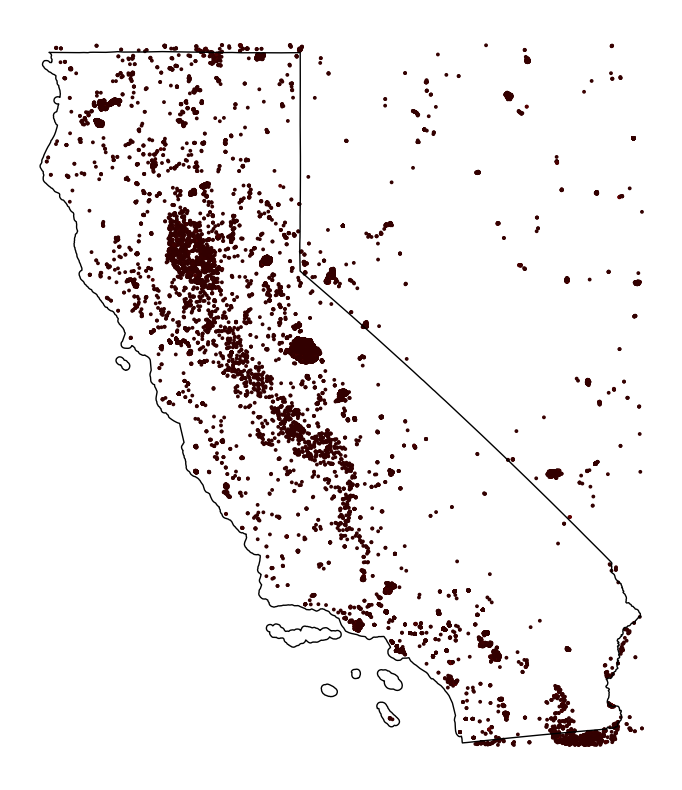

In [774]:
ax = fire_gdf.plot(markersize=3, figsize=(11,10), column='frp', cmap=afmhot2)
ca = ca_bd.to_crs(crs=4326).plot(ax =ax, color='none', edgecolor='black')
ax.axis('off')
plt.show()

In [775]:
fire_grid_gdf = gpd.sjoin(fire_gdf,ca_gdf, how='left', predicate='within')
fire_grid_gdf.tail(1)

,acq_date,frp,cnt,geometry,index_right
49459,2013-12-31,7.42,1,POINT (-120.70424 41.49223),1724.0


In [776]:
dissolve1 = fire_grid_gdf.dissolve(by='index_right', aggfunc='sum')
ca_gdf.loc[dissolve1.index, 'frp'] = dissolve1.frp.values

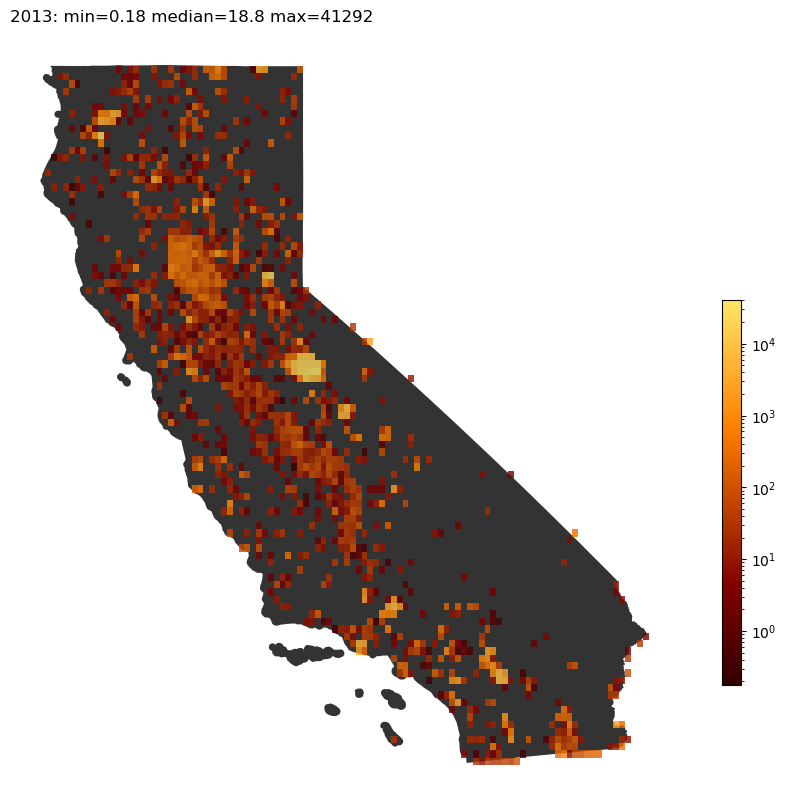

In [777]:
v1 = [dissolve1.frp.values.min(),dissolve1.frp.values.max()]
n1 = logn(vmin=v1[0], vmax=v1[1])
ax1 = ca_gdf.plot(figsize=(11,10), column='frp', cmap=afmhot2, alpha=0.8, markersize=1, 
                  vmin=v1[0], vmax=v1[1], norm=n1, zorder=2)
ax1.axis('off')
ca = ca_bd.to_crs(crs=4326).plot(ax=ax1, color='#333', zorder=1) # Plot state boundary
plt.colorbar(cm.ScalarMappable(norm=n1, cmap=afmhot2), ax=ax1,
             location='right', anchor=(0, 0.3), shrink=0.5) # Configure colorbar
plt.title(f'{yr}: min={v1[0]:.{2}f} median={np.median(dissolve1.frp.values):.{1}f} max={v1[1]:.{0}f}', loc='left')
ax.axis('off')
plt.savefig(f'../outputs/nasa-firms/images/frp_{yr}.png')
plt.show()

In [778]:
dissolve2 = fire_grid_gdf.dissolve(by='index_right', aggfunc='count')
ca_gdf.loc[dissolve2.index, 'cnt'] = dissolve2.cnt.values

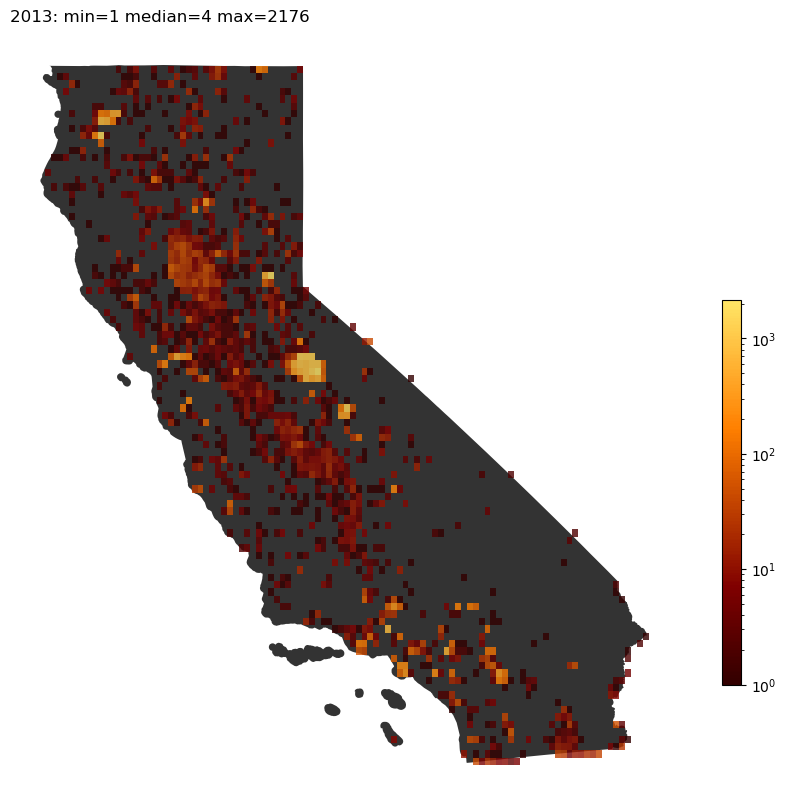

In [779]:
v2 = [dissolve2.cnt.values.min(),dissolve2.cnt.values.max()]
n2 = logn(vmin=v2[0], vmax=v2[1])
ax2 = ca_gdf.plot(figsize=(11,10), column='cnt', cmap=afmhot2, alpha=0.8, markersize=1, 
                  vmin=v2[0], vmax=v2[1], norm=n2, zorder=2)
ax2.axis('off')
ca = ca_bd.to_crs(crs=4326).plot(ax=ax2, color='#333', zorder=1) # Plot state boundary
plt.colorbar(cm.ScalarMappable(norm=n2, cmap=afmhot2), ax=ax2,
             location='right', anchor=(0, 0.3), shrink=0.5) # Configure colorbar
plt.title(f'{yr}: min={v2[0]} median={np.median(dissolve2.cnt.values):.{0}f} max={v2[1]}', loc='left')
ax2.axis('off')
plt.savefig(f'../outputs/nasa-firms/images/cnt_{yr}.png')
plt.show()

In [780]:
# Set cmap scale
n1 = logn(vmin=0.08, vmax=round(v1[1]+500,-3))
if v1[1]>35000: n1 = logn(vmin=0.08, vmax=round(v1[1]+5000,-4))
n2 = logn(vmin=1, vmax=round(v2[1]+50,-2))

In [781]:
# variables to store
st_frp_df = pd.DataFrame(columns=dt)
st_cnt_df = pd.DataFrame(columns=dt)
# Loop through months and output fire plots
for d in dt:
    # Read CA grid file to get gridded shapes
    ca_gdf = gpd.read_file('../outputs/geojson/ca_grid.geojson')
    # Group Fire by month
    mo_gdf = fire_gdf.loc[fire_df['acq_date'].str[0:7] == d][['frp','cnt','geometry']]
    # Sjoin to isolate fire within CA grid
    mo_grid_gdf = gpd.sjoin(mo_gdf,ca_gdf, how='left', predicate='within')
    
    # Dissolve on sum of frp of gdf data on sjoin
    dissolve1 = mo_grid_gdf.dissolve(by='index_right', aggfunc='sum')
    ca_gdf.loc[dissolve1.index, 'frp'] = dissolve1.frp.values
    # Store statistical information
    st_frp_df[d] = pd.Series(dissolve1.frp.values)
    st1 = [f'{dissolve1.frp.values.min():.{2}f}',
           f'{np.median(dissolve1.frp.values):.{1}f}',
           f'{dissolve1.frp.values.max():.{0}f}']
    # Plot ca cells
    ax1 = ca_gdf.plot(figsize=(11,10), column='frp', cmap=afmhot2, alpha=0.8,
                      markersize=1, vmin=0.1, vmax=12000, norm=n1, zorder=2)
    ax1.axis('off')
    ca = ca_bd.to_crs(crs=4326).plot(ax=ax1, color='#333', zorder=1) # Plot state boundary
    plt.colorbar(cm.ScalarMappable(norm=n1, cmap=afmhot2), ax=ax1, 
                 location='right', anchor=(0, 0.3), shrink=0.5) # Configure colorbar
    plt.title(f'{d}: min={st1[0]} median={st1[1]} max={st1[2]}', loc='left')
    plt.savefig(f'../outputs/nasa-firms/images/frp/frp_{d}.png')
    plt.close()

    # Dissolve on count of fire cell of gdf data on sjoin
    dissolve2 = mo_grid_gdf.dissolve(by='index_right', aggfunc='count')
    ca_gdf.loc[dissolve2.index, 'cnt'] = dissolve2.cnt.values
    # Store statistical information
    st_cnt_df[d] = pd.Series(dissolve2.cnt.values)
    st2 = [f'{dissolve2.cnt.values.min()}',
           f'{np.median(dissolve2.cnt.values):.{0}f}',
           f'{dissolve2.cnt.values.max():.{0}f}']
    # Plot ca cells
    ax2 = ca_gdf.plot(figsize=(11,10), column='cnt', cmap=afmhot2, alpha=0.8,
                      markersize=1, vmin=0.1, vmax=12000, norm=n2, zorder=2)
    ca = ca_bd.to_crs(crs=4326).plot(ax=ax2, color='#333', zorder=1) # Plot state boundary
    plt.colorbar(cm.ScalarMappable(norm=n2 ,cmap=afmhot2), ax=ax2, 
                 location='right', anchor=(0, 0.3), shrink=0.5) # Configure colorbar
    plt.title(f'{d} min={st2[0]} median={st2[1]} max={st2[2]}', loc='left')
    ax2.axis('off')
    plt.savefig(f'../outputs/nasa-firms/images/cnt/cnt_{d}.png')
    plt.close()

In [782]:
st_frp_df.to_csv(f'../outputs/nasa-firms/boxplot/frp/{yr}.csv',index=False)
st_cnt_df.to_csv(f'../outputs/nasa-firms/boxplot/cnt/{yr}.csv',index=False)